<a href="https://colab.research.google.com/github/AtharBagunaid/Face-mask-detector/blob/main/Soft_computing_Detect_Face_Mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.applications import vgg16
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import tensorflow
# from tensorflow.keras.applications import vgg16

In [2]:
!pwd

/content


In [3]:
cd "/content/drive/MyDrive/Colab Notebooks/DIP/Mask_detection"

/content/drive/MyDrive/Colab Notebooks/DIP/Mask_detection


In [4]:
!pwd

/content/drive/MyDrive/Colab Notebooks/DIP/Mask_detection


## Data preparation

In [5]:
train_path = "/content/drive/MyDrive/Colab Notebooks/DIP/Mask_detection/train"
valid_path = "/content/drive/MyDrive/Colab Notebooks/DIP/Mask_detection/valid"
test_path = "/content/drive/MyDrive/Colab Notebooks/DIP/Mask_detection/test"

In [6]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size = (224,224), classes = ['with_mask', 'without_mask'], batch_size = 100, class_mode = 'categorical')
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size = (224,224), classes = ['with_mask', 'without_mask'], batch_size = 100, class_mode = 'categorical')
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size = (224,224), classes = ['with_mask', 'without_mask'], batch_size = 200, class_mode = 'categorical')

Found 4696 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
Found 2236 images belonging to 2 classes.


In [7]:
train_image_count = len([f for f in os.listdir(train_path)])
train_image_count

2

In [8]:
def plots(ims, figsize = (20,20), rows = 10, interp = False, titles = None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize = 16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')

In [9]:
imgs, labels = next(train_batches) 

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


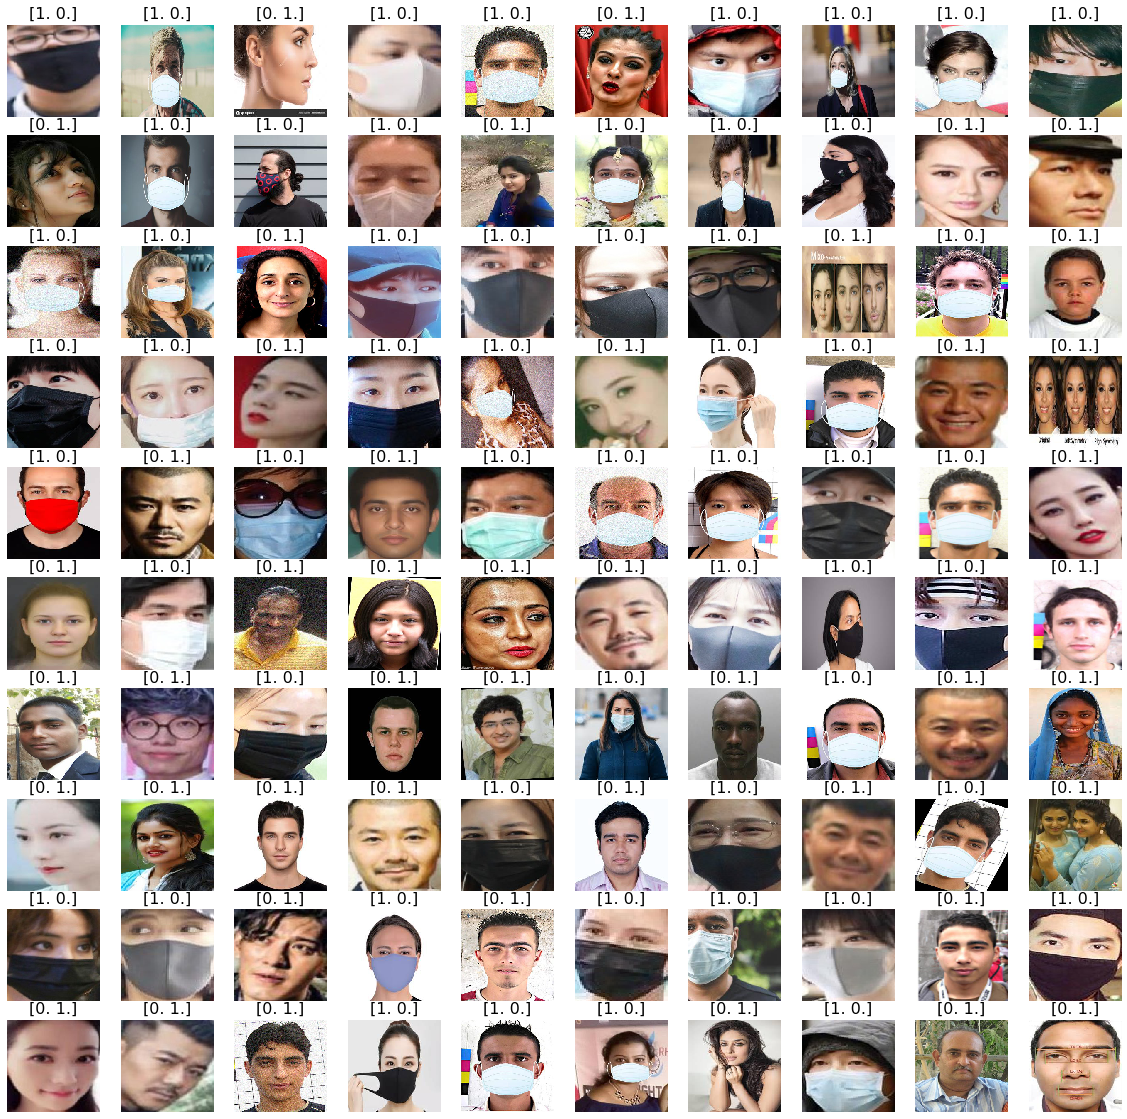

In [10]:
plots(imgs, titles = labels)   

## vgg-16 model preparation

In [11]:
vgg16_model = keras.applications.vgg16.VGG16()

In [12]:
# show the built in model structure
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
# copy all layers of vgg16 into sequential model except the last layer
# then add output layer with 2 classes and softmax as activation function
model = Sequential()
for layer in vgg16_model.layers[:-1]:
  model.add(layer)

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

## Train the model using the train set

In [15]:
# Compile the model
model.compile(Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
# fitting / training the model
model.fit_generator(train_batches, steps_per_epoch=46, validation_data=valid_batches, validation_steps=5, epochs= 15, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
46/46 [==============================] - 115s 2s/step - loss: 0.7544 - accuracy: 0.6961 - val_loss: 0.3599 - val_accuracy: 0.8320
Epoch 2/15
46/46 [==============================] - 42s 915ms/step - loss: 0.1569 - accuracy: 0.9430 - val_loss: 0.2533 - val_accuracy: 0.8840
Epoch 3/15
46/46 [==============================] - 43s 922ms/step - loss: 0.1063 - accuracy: 0.9613 - val_loss: 0.1918 - val_accuracy: 0.9160
Epoch 4/15
46/46 [==============================] - 43s 920ms/step - loss: 0.0732 - accuracy: 0.9747 - val_loss: 0.1766 - val_accuracy: 0.9260
Epoch 5/15
46/46 [==============================] - 42s 918ms/step - loss: 0.0614 - accuracy: 0.9810 - val_loss: 0.1429 - val_accuracy: 0.9420
Epoch 6/15
46/46 [==============================] - 43s 919ms/step - loss: 0.0547 - accuracy: 0.9806 - val_loss: 0.1380 - val_accuracy: 0.9500
Epoch 7/15
46/46 [==============================] - 43s 920ms/step - loss: 0.0504 - accuracy: 0.9841 - val_loss: 0.1135 - val_accuracy: 0.9640
E

We notice from the above results that the accuracy increased from 0.6 at the first epoch up to 0.9794 in the last epoch

In [17]:
model.save('/content/drive/My Drive/Colab Notebooks/faceMask_detection.h5')
print('saved sucessfully')

saved sucessfully


In [18]:
vgg16_model1 = keras.applications.vgg16.VGG16()

model1 = Sequential()
for layer in vgg16_model1.layers[:-1]:
  model1.add(layer)

# Freeze the layers 
for layer in model1.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model1.add(Dense(2, activation='softmax'))

In [19]:
model1.load_weights('/content/drive/My Drive/Colab Notebooks/faceMask_detection.h5')
classes = ["with mask", "without mask"]


In [20]:
predictions1 = model1.predict(test_batches, steps= 12, verbose = 0)
predictions1

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


array([[7.87024348e-08, 9.99999881e-01],
       [1.23526454e-01, 8.76473546e-01],
       [1.01885871e-06, 9.99998927e-01],
       ...,
       [9.99760926e-01, 2.39127854e-04],
       [1.81529701e-01, 8.18470359e-01],
       [5.82137227e-01, 4.17862743e-01]], dtype=float32)

In [21]:
prediction_classes = model1.predict_classes(test_batches, batch_size=200, verbose = 0)

pred_class = []
for i in prediction_classes:
  pred_class.append(classes[i])
  
print(np.array(pred_class).shape)
print(np.array(pred_class))


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


(2236,)
['without mask' 'with mask' 'with mask' ... 'without mask' 'without mask'
 'without mask']


In [22]:
# combine the test labels in one array
test_labels = []
# test_labels = np.array(test_labels).reshape(-1,2)
for i in range(len(test_batches)):
  test_labels = test_labels + list(next(test_batches)[1])


len(test_labels)
test_labels = np.array(test_labels)
# test_labels = test_labels[:,0]
test_labels

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

Text(89.18, 0.5, 'predicted label')

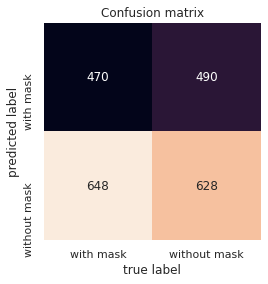

In [23]:
# draw the confusion matrix
predictions_idx = np.argmax(predictions1, axis=1)
test_labels_idx = np.argmax(test_labels, axis=1)
cm_labels = ['with mask', 'without mask']

from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

mat = confusion_matrix(test_labels_idx, predictions_idx)
mat # this is the conv matrix
# create the heat map
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=cm_labels, yticklabels=cm_labels)

#ploting heatmap of confusion matrix
plt.title("Confusion matrix")
plt.xlabel('true label')
plt.ylabel('predicted label')

In [24]:
# to display an image
from PIL import Image
import numpy as np
from skimage import transform
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

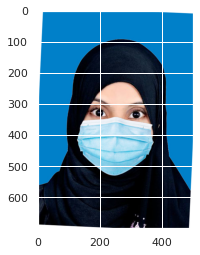

with mask


In [27]:
image = load("/content/drive/MyDrive/Uploads to transfer/with_mask_00.jpg")
img = mpimg.imread("/content/drive/MyDrive/Uploads to transfer/with_mask_00.jpg")
imgplot = plt.imshow(img)
plt.show()
print(classes[np.argmax(model1.predict(image))])

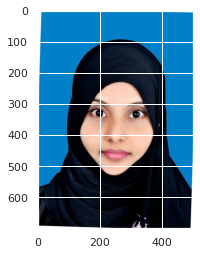

with mask


In [28]:
image1 = load("/content/drive/MyDrive/Uploads to transfer/with_mask_00.jpg")
img1 = mpimg.imread("/content/drive/MyDrive/Uploads to transfer/without_mask_00.jpg")
imgplot = plt.imshow(img1)
plt.show()
print(classes[np.argmax(model1.predict(image1))])